In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from scipy.linalg import cholesky, lstsq


In [23]:
from experiments import MoreTraceGases, Sensors
from experiments import utilities as utils
from bayesinverse import Regression
from robiplotipy import PlotEnv
import robiplotipy.experiments.more_trace_gases as plt_exp

In [64]:
config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/more_trace_gases/config.yaml"
)

exp = MoreTraceGases(config_path)
# basic_setup.run()


sensors 0.0029126405715942383


/home/rmaiwald/code/Experiments/experiments/shared/emissions.py:301: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  tno_points_gdf = pickle.load(file)


emissions 1.8820858597755432
transport 5.8507971316576


In [65]:
plot_env = PlotEnv(
    fig_path="/home/rmaiwald/results/plotting/more_trace_gases/",
    logging=True,
    display=True,
)


In [66]:
exp.sensors_config

{'n_sensors': 10, 'height': 0, 'noise': 1.0, 'seed': 42, 'time': 120}

In [67]:
# CO2 sensors
exp.sensors_co2 = Sensors(exp.sensors_config)

# CO sensors
co_config = exp.sensors_config
co_config["noise"] = .002
co_config["seed"] = 5
exp.sensors_co = Sensors(exp.sensors_config)

In [68]:
em_factors_co = exp.emissions.get_emission_factors()[exp.emissions.mask]
em_factors = xr.DataArray(em_factors_co, dims=["source_group"])

/home/rmaiwald/code/Experiments/experiments/shared/emissions.py:374: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  tno_points_gdf = pickle.load(file)


In [69]:
exp.load_data()
posterior = exp.data["posterior"]
posterior_combined = exp.data["posterior_combined"]
posterior_covariance = exp.data["posterior_covariance"]
posterior_combined_covariance = exp.data["posterior_combined_covariance"]

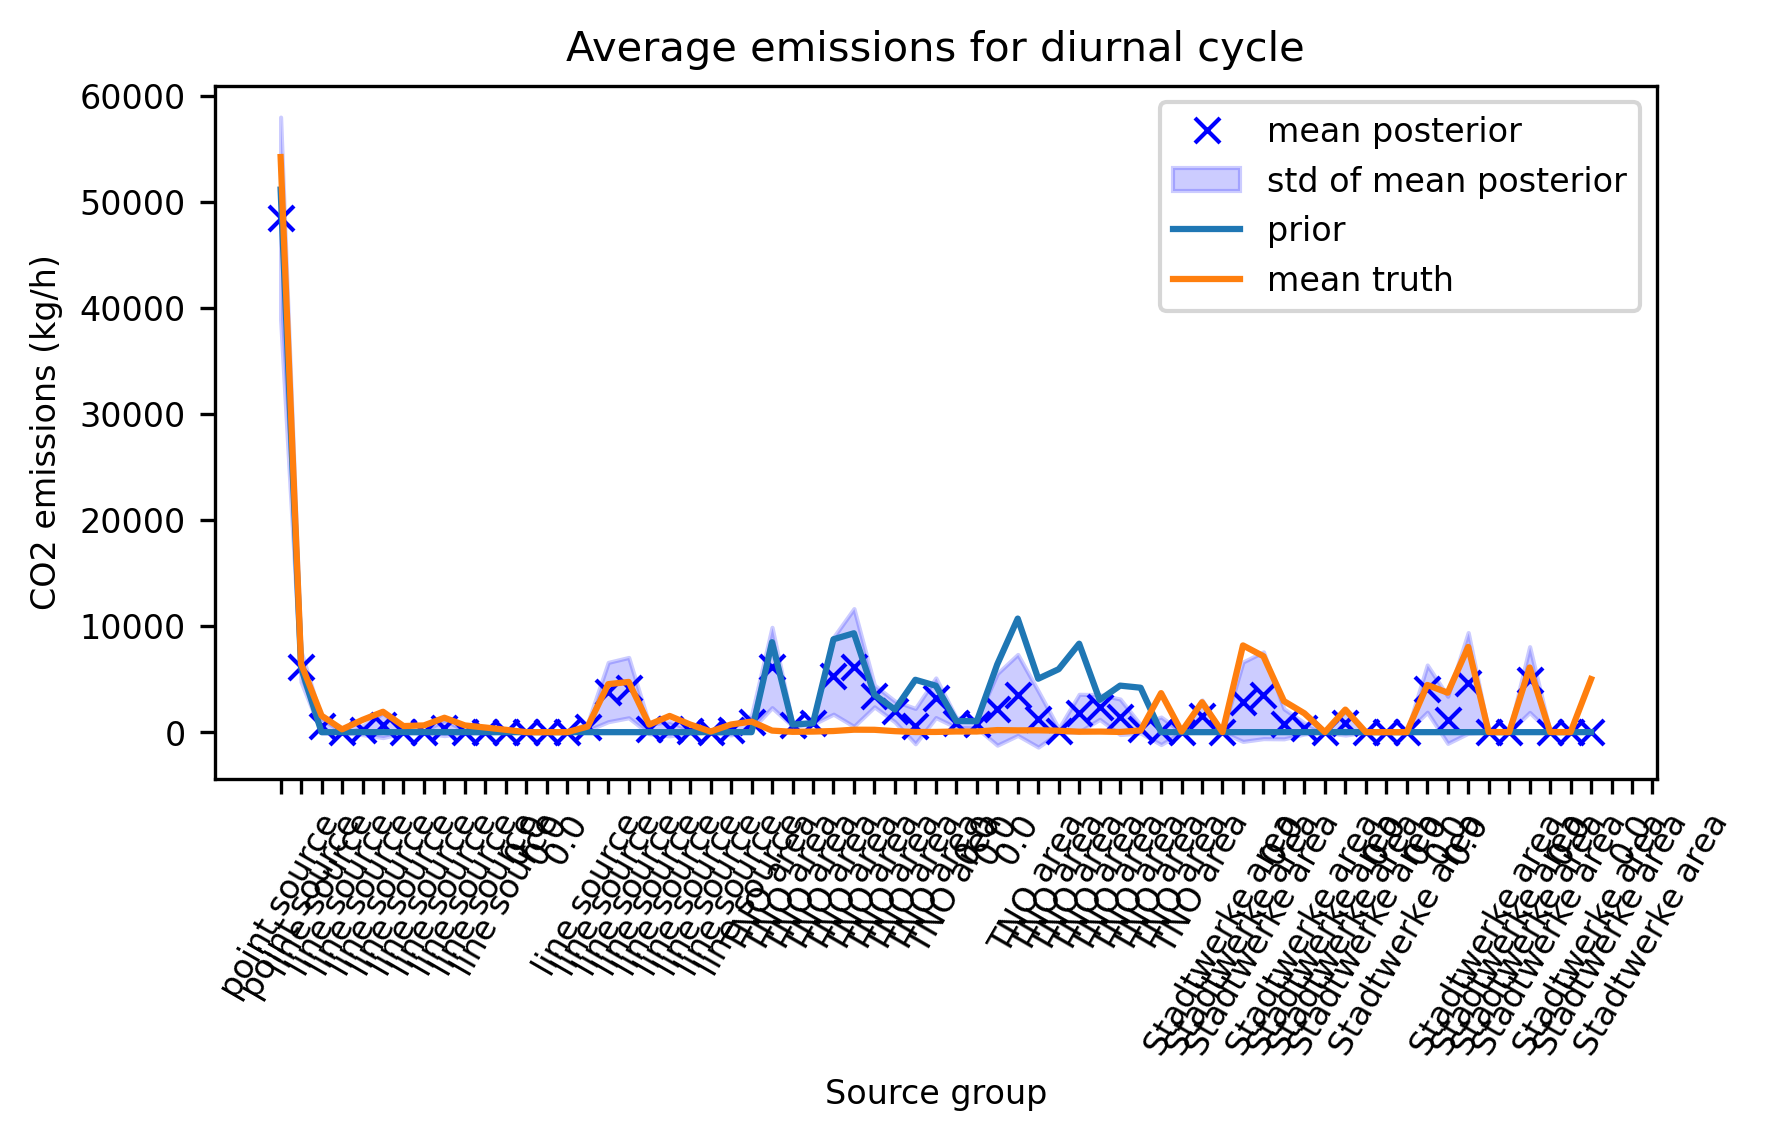

In [70]:
mean = utils.unstack_xr(posterior).mean("time_state")
std = utils.unstack_xr(posterior).std("time_state")
line = plt.plot(mean, "bx", label="mean posterior")[0]
plt.fill_between(
    range(len(mean)),
    mean - std,
    mean + std,
    alpha=0.2,
    color=line._color,
    label="std of mean posterior",
)

plt.plot(exp.emissions.prior_absolute.mean("time_state"), label="prior")
plt.plot(exp.emissions.truth_absolute.mean("time_state"), label="mean truth")
plt.xlabel("Source group")
plt.ylabel("CO2 emissions [kg/h]")
plt.legend()
ticks = list(exp.emissions.source_group_df["source_type"].values)
plt.xticks(np.arange(len(ticks)), ticks, rotation=60)
plt.title("Average emissions for diurnal cycle")
pass


In [71]:
point_index = exp.emissions.source_group_df.query("source_type == 'point source'").index
traffic_index = exp.emissions.source_group_df.query("source_type == 'line source'").index
tno_area_index = exp.emissions.source_group_df.query("source_type == 'TNO area'").index
heating_index = exp.emissions.source_group_df.query("source_type == 'Stadtwerke area'").index
valid_index = exp.emissions.source_group_df.query("source_type != '0.0'").index

All sources

In [97]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=valid_index,
)
y_label = r"Total CO$_2$ emissions [kg/h]"

In [98]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 21664.493704802186
RMSE: 22132.344244672207


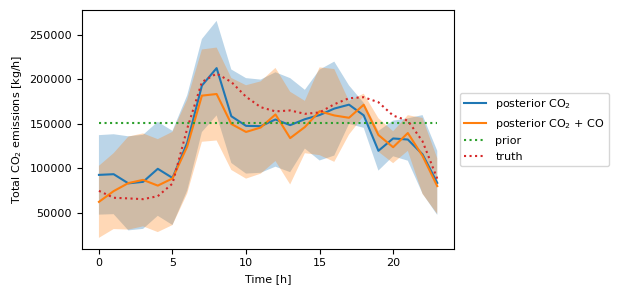

In [99]:
with plot_env(name="total", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
    )

Without points

In [100]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=valid_index[2:],
)


In [101]:
y_label = r"Total CO$_2$ emissions""\n""without point sources [kg/h]"

In [102]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 12067.425753486103
RMSE: 11034.826210598101


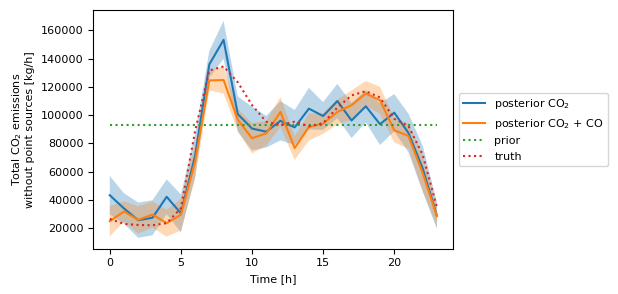

In [103]:
with plot_env(name="without_points", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
    )

Points

In [104]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=point_index,
)


In [105]:
y_label = r"Total CO$_2$ emissions from point sources [kg/h]"

In [106]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 14893.48977727038
RMSE: 14216.43029355356


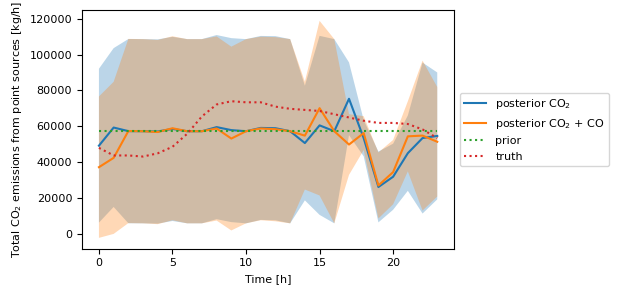

In [108]:
with plot_env(name="points", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
    )

Traffic

In [109]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=traffic_index,
)


In [110]:
y_label = r"Total CO$_2$ emissions from line sources [kg/h]"

In [111]:
exp.config

{'emissions': {'correlation': {'tau_d': 0.001, 'tau_h': 0.001},
  'prior': 'mean_TNO_with_points',
  'prior_mode': 'constant_diurnal',
  'prior_variance': 'mean_TNO_variance',
  'truth': 'combined_emissions',
  'truth_mode': 'single_diurnal'},
 'paths': {'data_jar': '/home/rmaiwald/results/experiments/'},
 'reader': {'catalog_path': '/mnt/data/users/rmaiwald/GRAMM-GRAL/gral/gramm_catalog/',
  'config_path': '/mnt/data/users/rmaiwald/GRAMM-GRAL/gral/gral_sim_path_05/config/',
  'simulation_path': '/mnt/data/users/rmaiwald/GRAMM-GRAL/gral/gral_sim_path_05/'},
 'seed': 42,
 'sensors': {'height': 0, 'n_sensors': 10, 'noise': 1.0},
 'time': 120,
 'transport': {'mode': 'realistic'}}

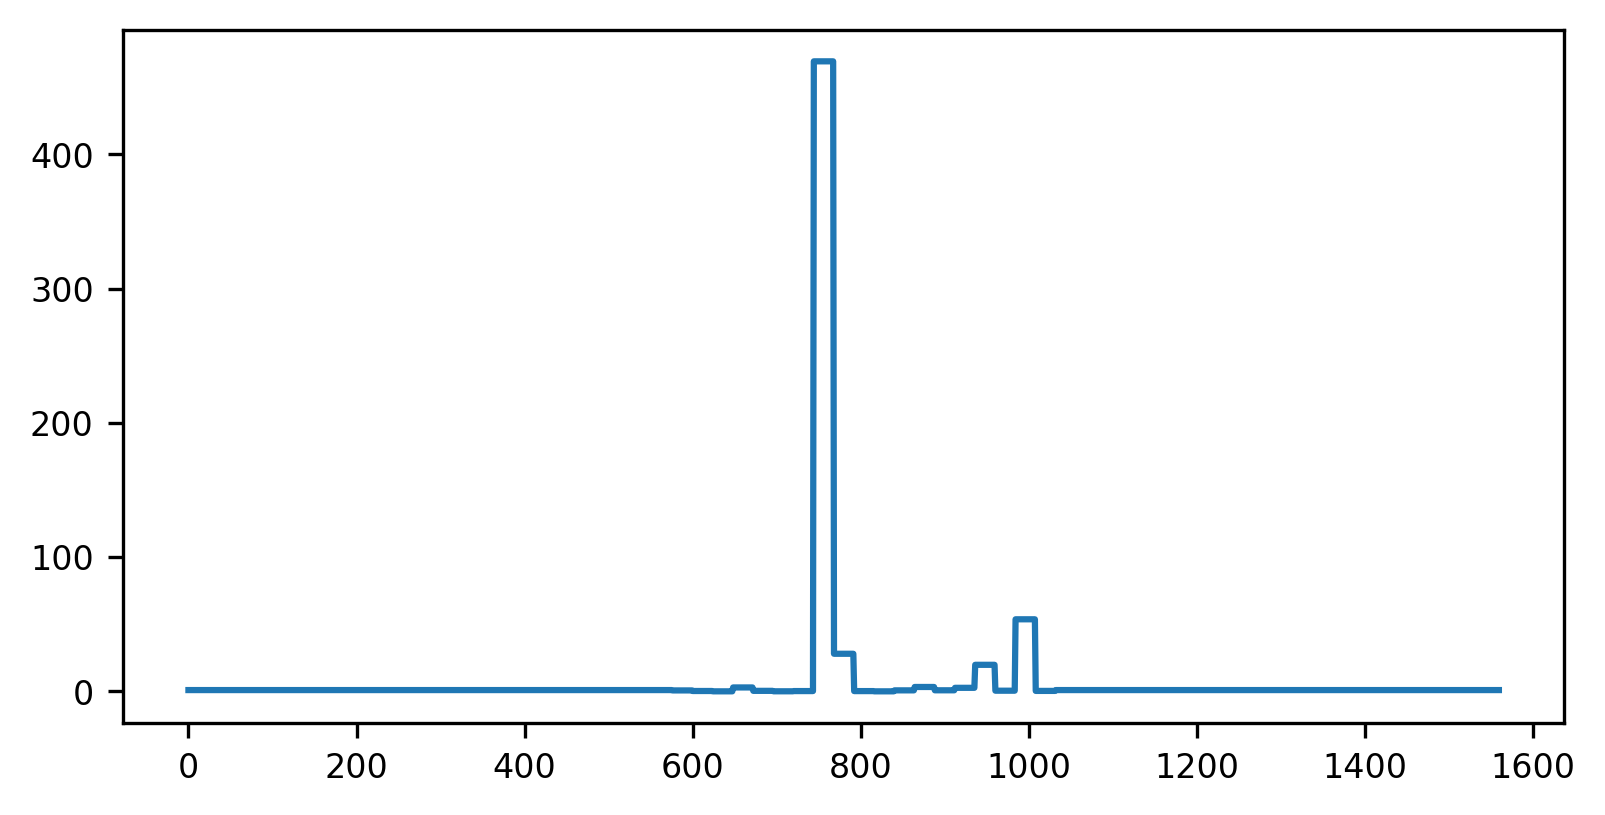

In [112]:
plt.plot(np.diag(utils.stack_xr(exp.emissions.prior_covariance).values))

In [113]:
covariance = utils.unstack_xr(exp.emissions.prior_covariance)
covariance = (
    covariance
    * exp.emissions.absolute_emissions
    * exp.emissions.absolute_emissions.rename({"source_group": "source_group_2"})
)

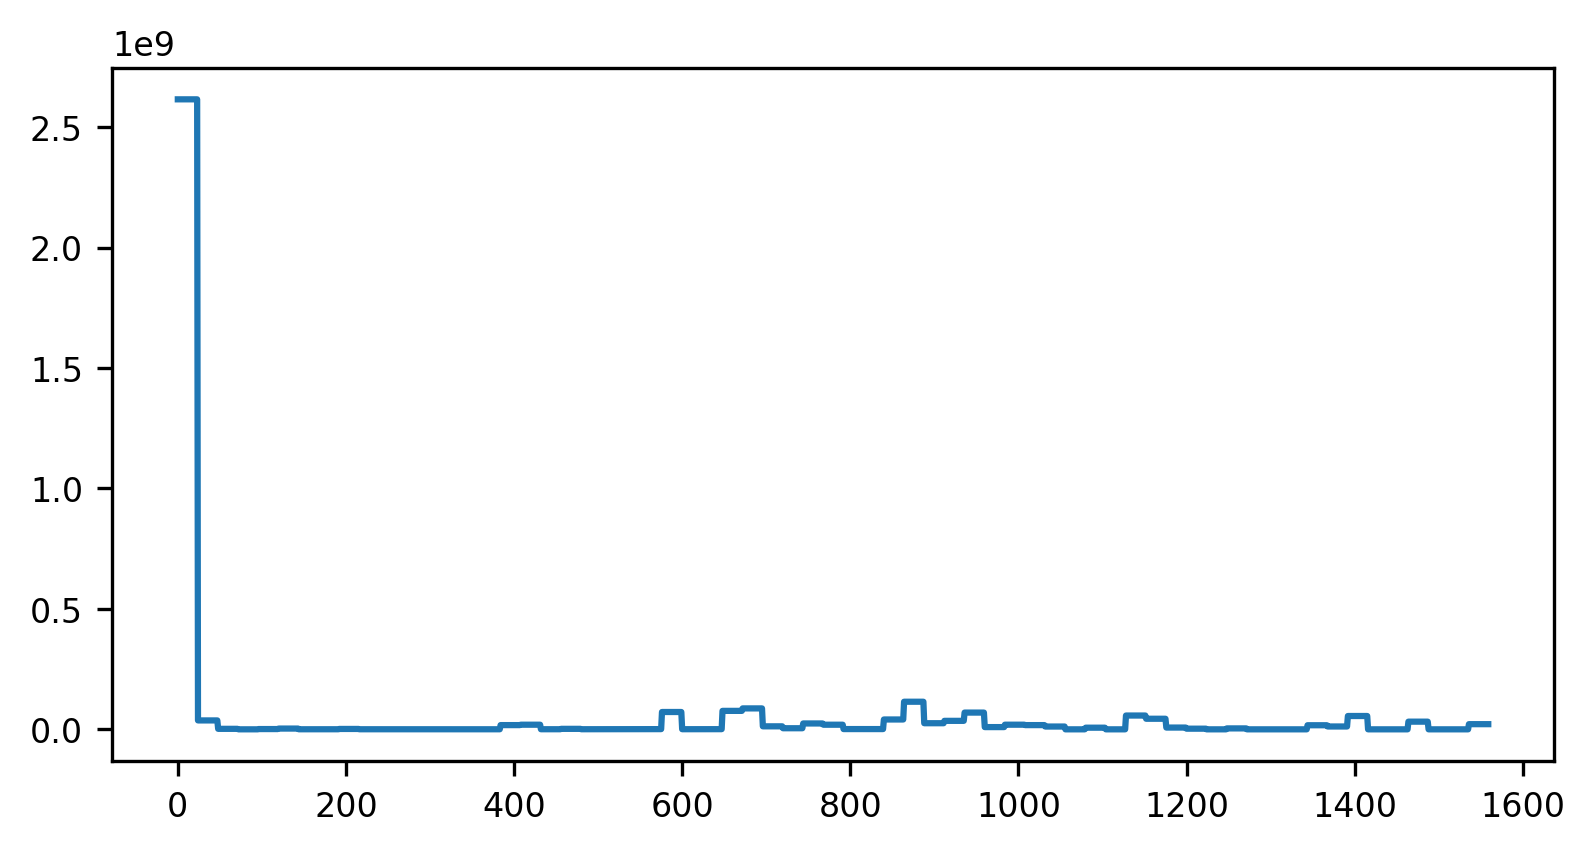

In [114]:
plt.plot(np.diag(utils.stack_xr(covariance).values))

In [115]:
true_emissions = exp.emissions.get_absolute()[exp.emissions.mask]

# Multiply with emissions
covariance = utils.unstack_xr(exp.emissions.prior_covariance) * true_emissions
covariance = covariance * true_emissions.rename(
    source_group="source_group_2"
)


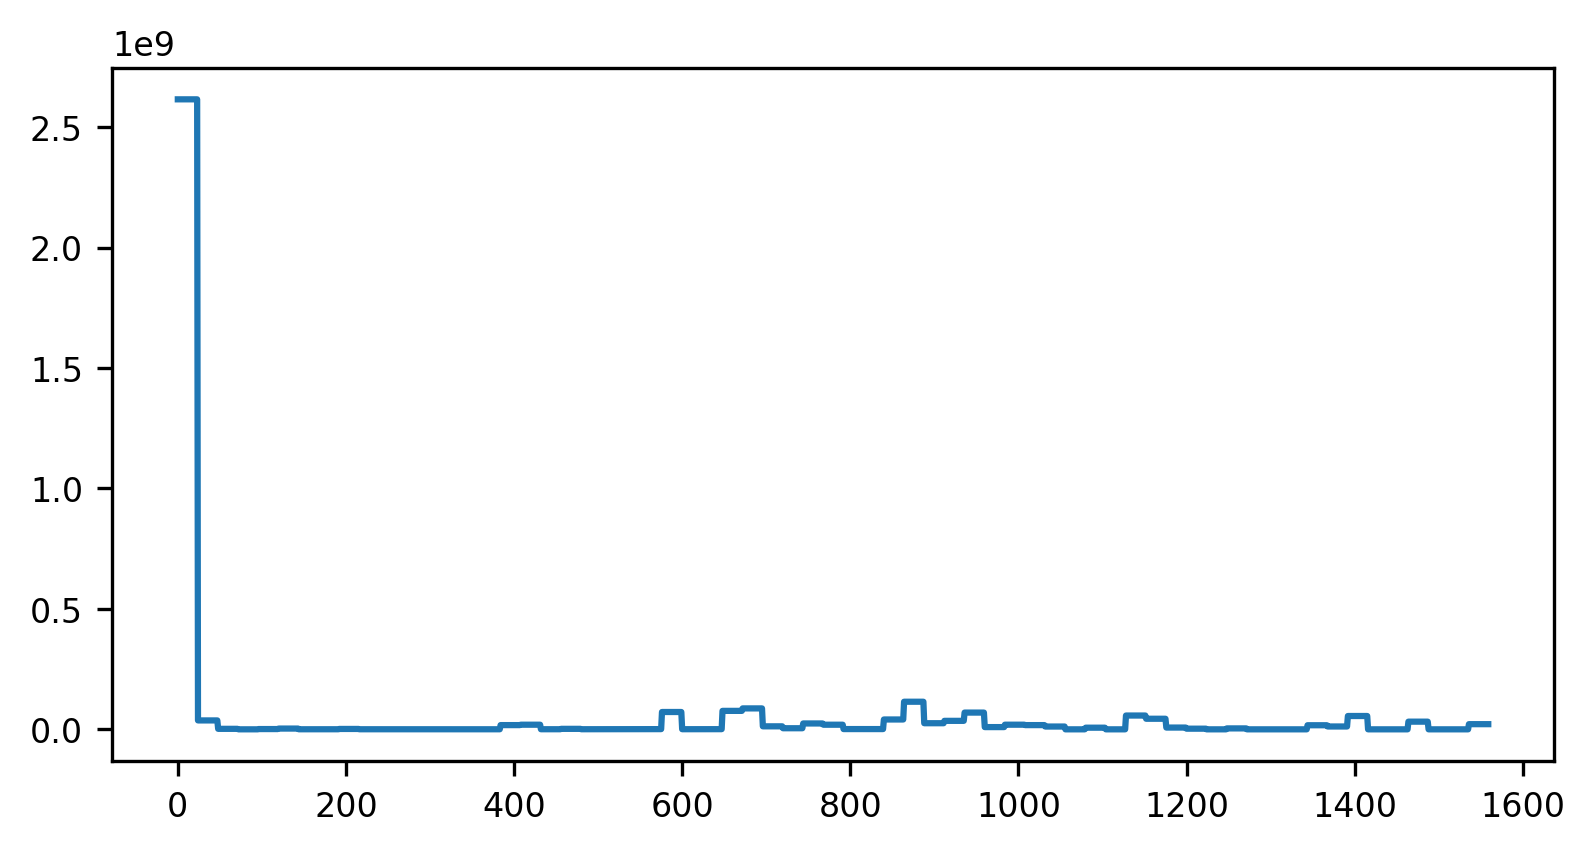

In [116]:
plt.plot(np.diag(utils.stack_xr(covariance).values))

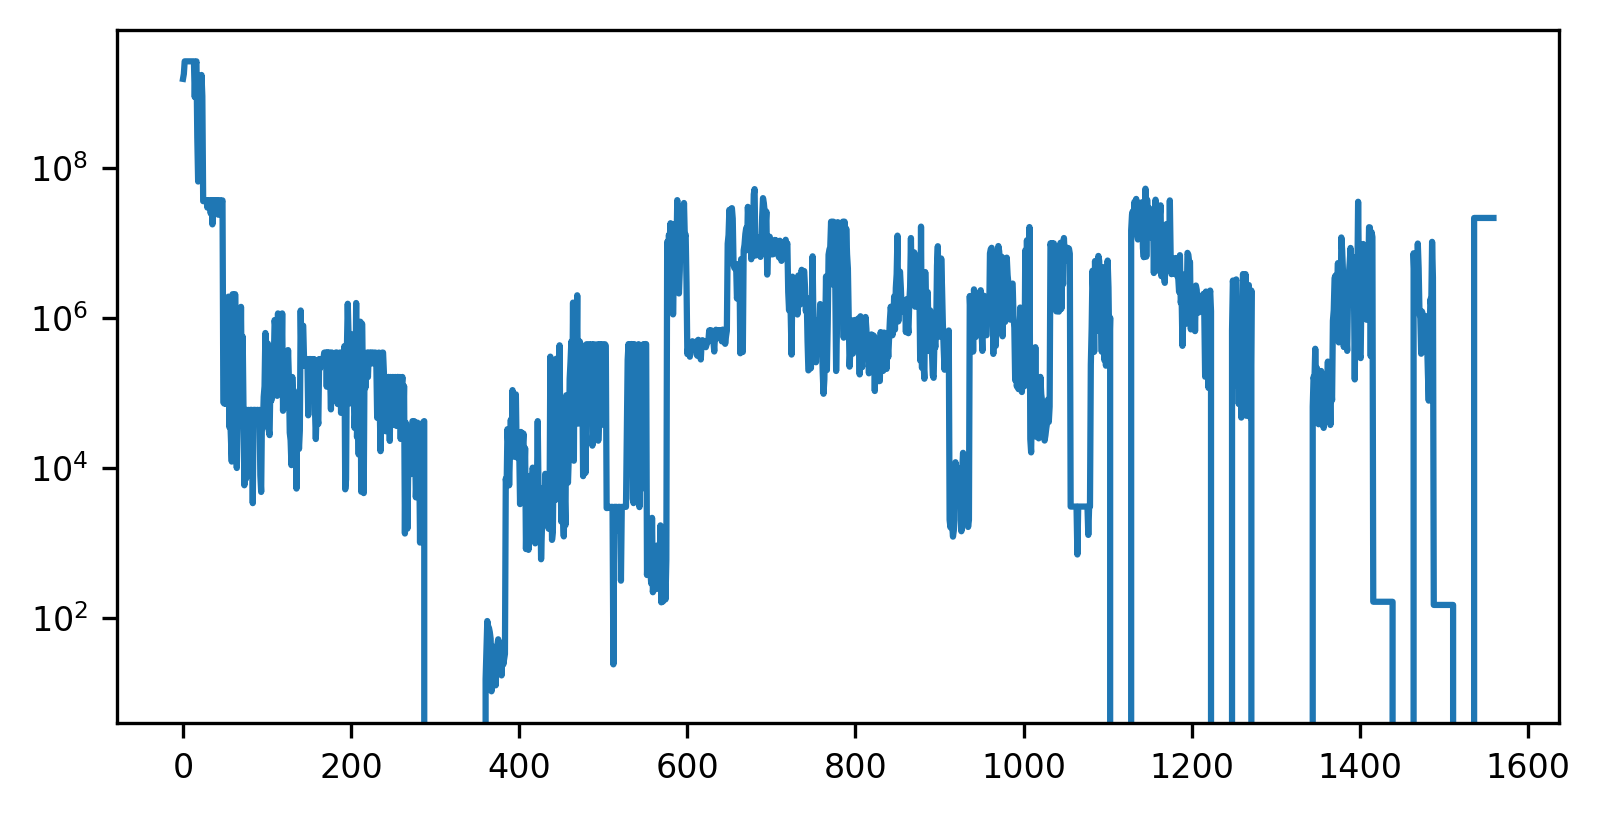

In [117]:
plt.plot(np.diag(utils.stack_xr(posterior_combined_covariance)))
plt.yscale("log")

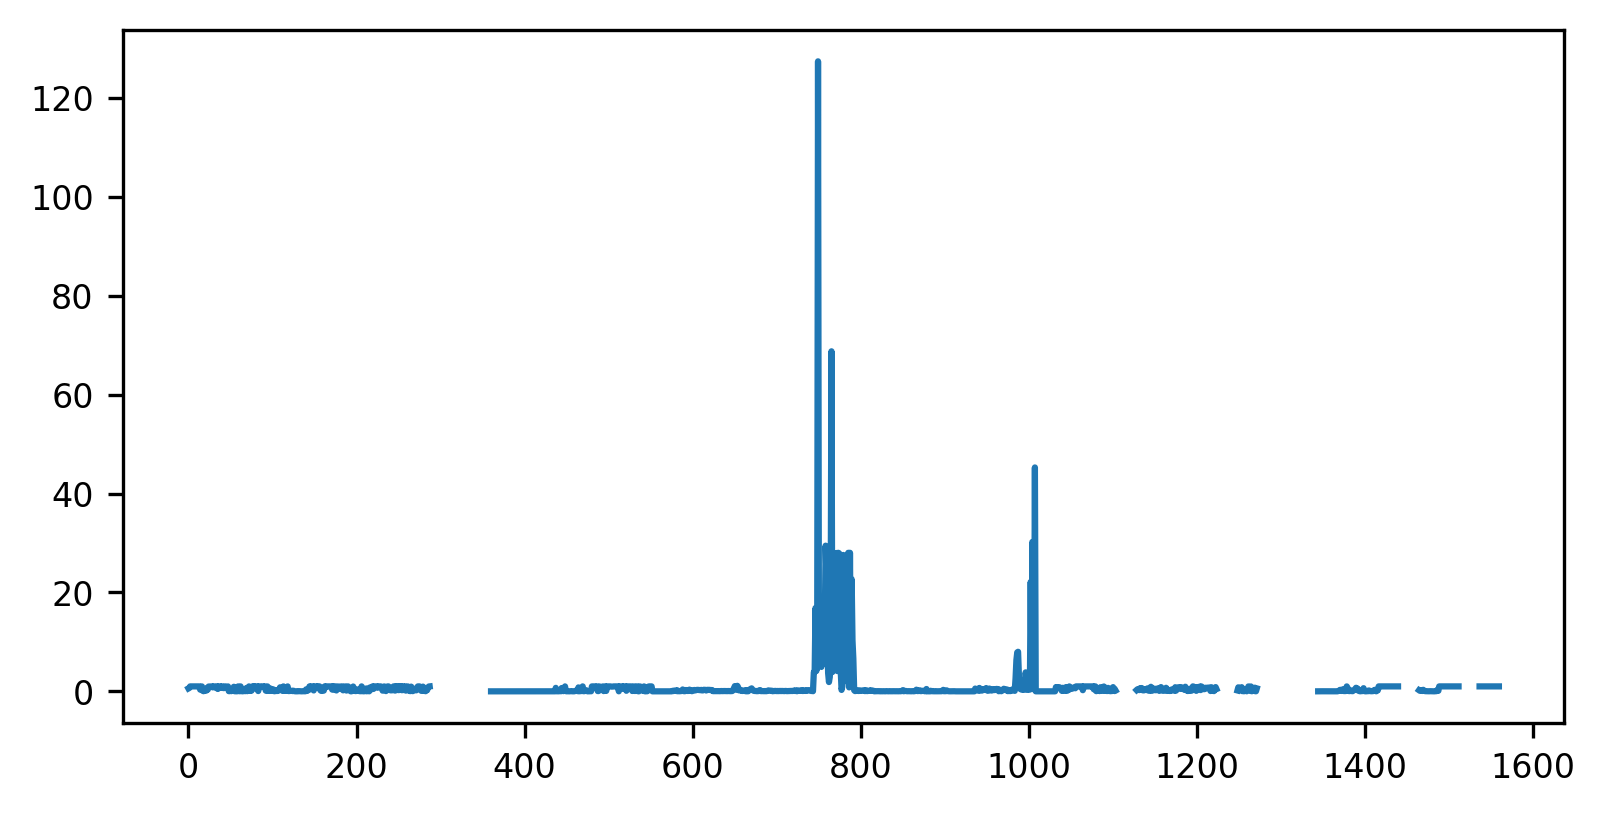

In [118]:
plt.plot(
    np.diag(
        utils.stack_xr(
            posterior_combined_covariance
            / exp.emissions.absolute_emissions
            / exp.emissions.absolute_emissions.rename(
                {"source_group": "source_group_2"}
            )
        ).values
    )
)


In [119]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 13035.416061092074
RMSE: 5225.347721144535


In [120]:
std

<xarray.DataArray (source_group: 65)>
array([9.53847820e+03, 1.43250516e+03, 6.57229360e+02, 4.46487176e+01,
       4.17544341e+02, 1.15152252e+03, 8.33095974e+01, 7.67597047e+01,
       7.27050422e+02, 1.19365431e+02, 5.88453788e+01, 2.44278261e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.50623711e+02,
       2.79610624e+03, 2.84343780e+03, 4.49078615e+02, 6.73884591e+02,
       1.51767546e+02, 9.64689446e+00, 4.55560349e+02, 6.62838562e+02,
       3.78800795e+03, 1.37885064e+02, 1.40464507e+02, 3.62606391e+03,
       5.55025549e+03, 1.02368068e+03, 9.78413945e+02, 1.66586320e+03,
       1.86739904e+03, 4.58878600e+02, 4.09279874e+02, 3.37577331e+03,
       3.81603332e+03, 2.64404387e+03, 1.90660130e+02, 1.77556928e+03,
       1.16107518e+03, 1.67410796e+03, 3.83202452e+02, 1.29633233e+03,
       1.23025960e+01, 1.53491327e+03, 0.00000000e+00, 3.74420493e+03,
       4.08977198e+03, 1.41542066e+03, 5.20471948e+02, 0.00000000e+00,
       1.13751857e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.22588533e+03, 2.22019734e+03, 4.74432240e+03, 9.51961741e-16,
       0.00000000e+00, 3.10096909e+03, 1.69917369e-17, 0.00000000e+00,
       0.00000000e+00])
Coordinates:
  * source_group  (source_group) int64 1 2 3 4 5 6 7 8 ... 62 63 64 65 66 67 68

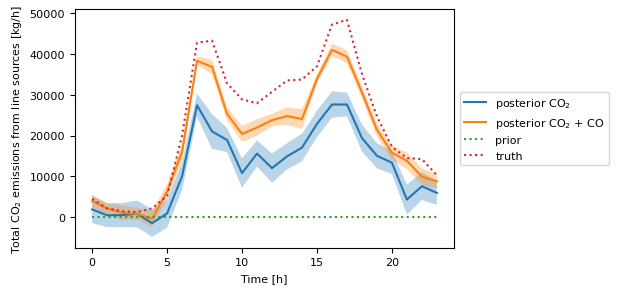

In [122]:
with plot_env(name="traffic", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
    )

Heating

In [123]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=heating_index,
)


In [127]:
y_label = r"Total CO$_2$ emissions""\n""from SWHD area sources [kg/h]"

In [128]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 34231.81409706296
RMSE: 23989.656503828173


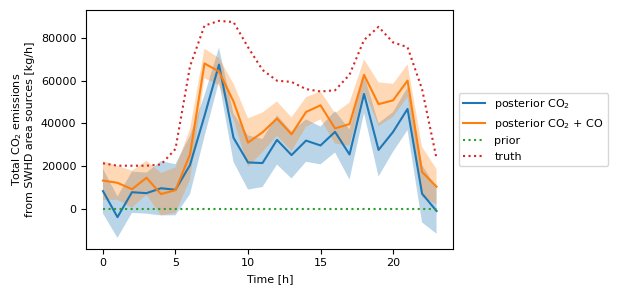

In [130]:
with plot_env(name="heating", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
        )

TNO area sources

In [131]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=tno_area_index,
)


In [132]:
y_label = r"Total CO$_2$ emissions ""\n""from TNO area sources [kg/h]"

In [133]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 42808.99814717915
RMSE: 20943.458794295642


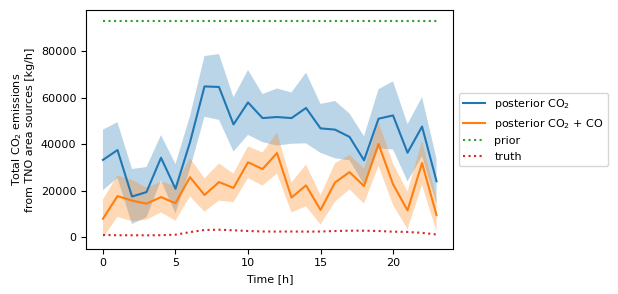

In [135]:
with plot_env(name="TNO area sources", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
    )

In [59]:
var = []
for coor, sub_arr in posterior_covariance.groupby('time_state'):
    cov = sub_arr.sel(time_state_2=coor).isel(source_group=slice(1, None))
    var.append(utils.var_of_sum(cov))

In [60]:
var_combined = []
for coor, sub_arr in posterior_combined_covariance.groupby('time_state'):
    cov = sub_arr.sel(time_state_2=coor).isel(source_group=slice(1, None))
    var_combined.append(utils.var_of_sum(cov))

RMSE: <xarray.DataArray ()>
array(37137.13161003)
RMSE with CO: <xarray.DataArray ()>
array(38198.85890452)


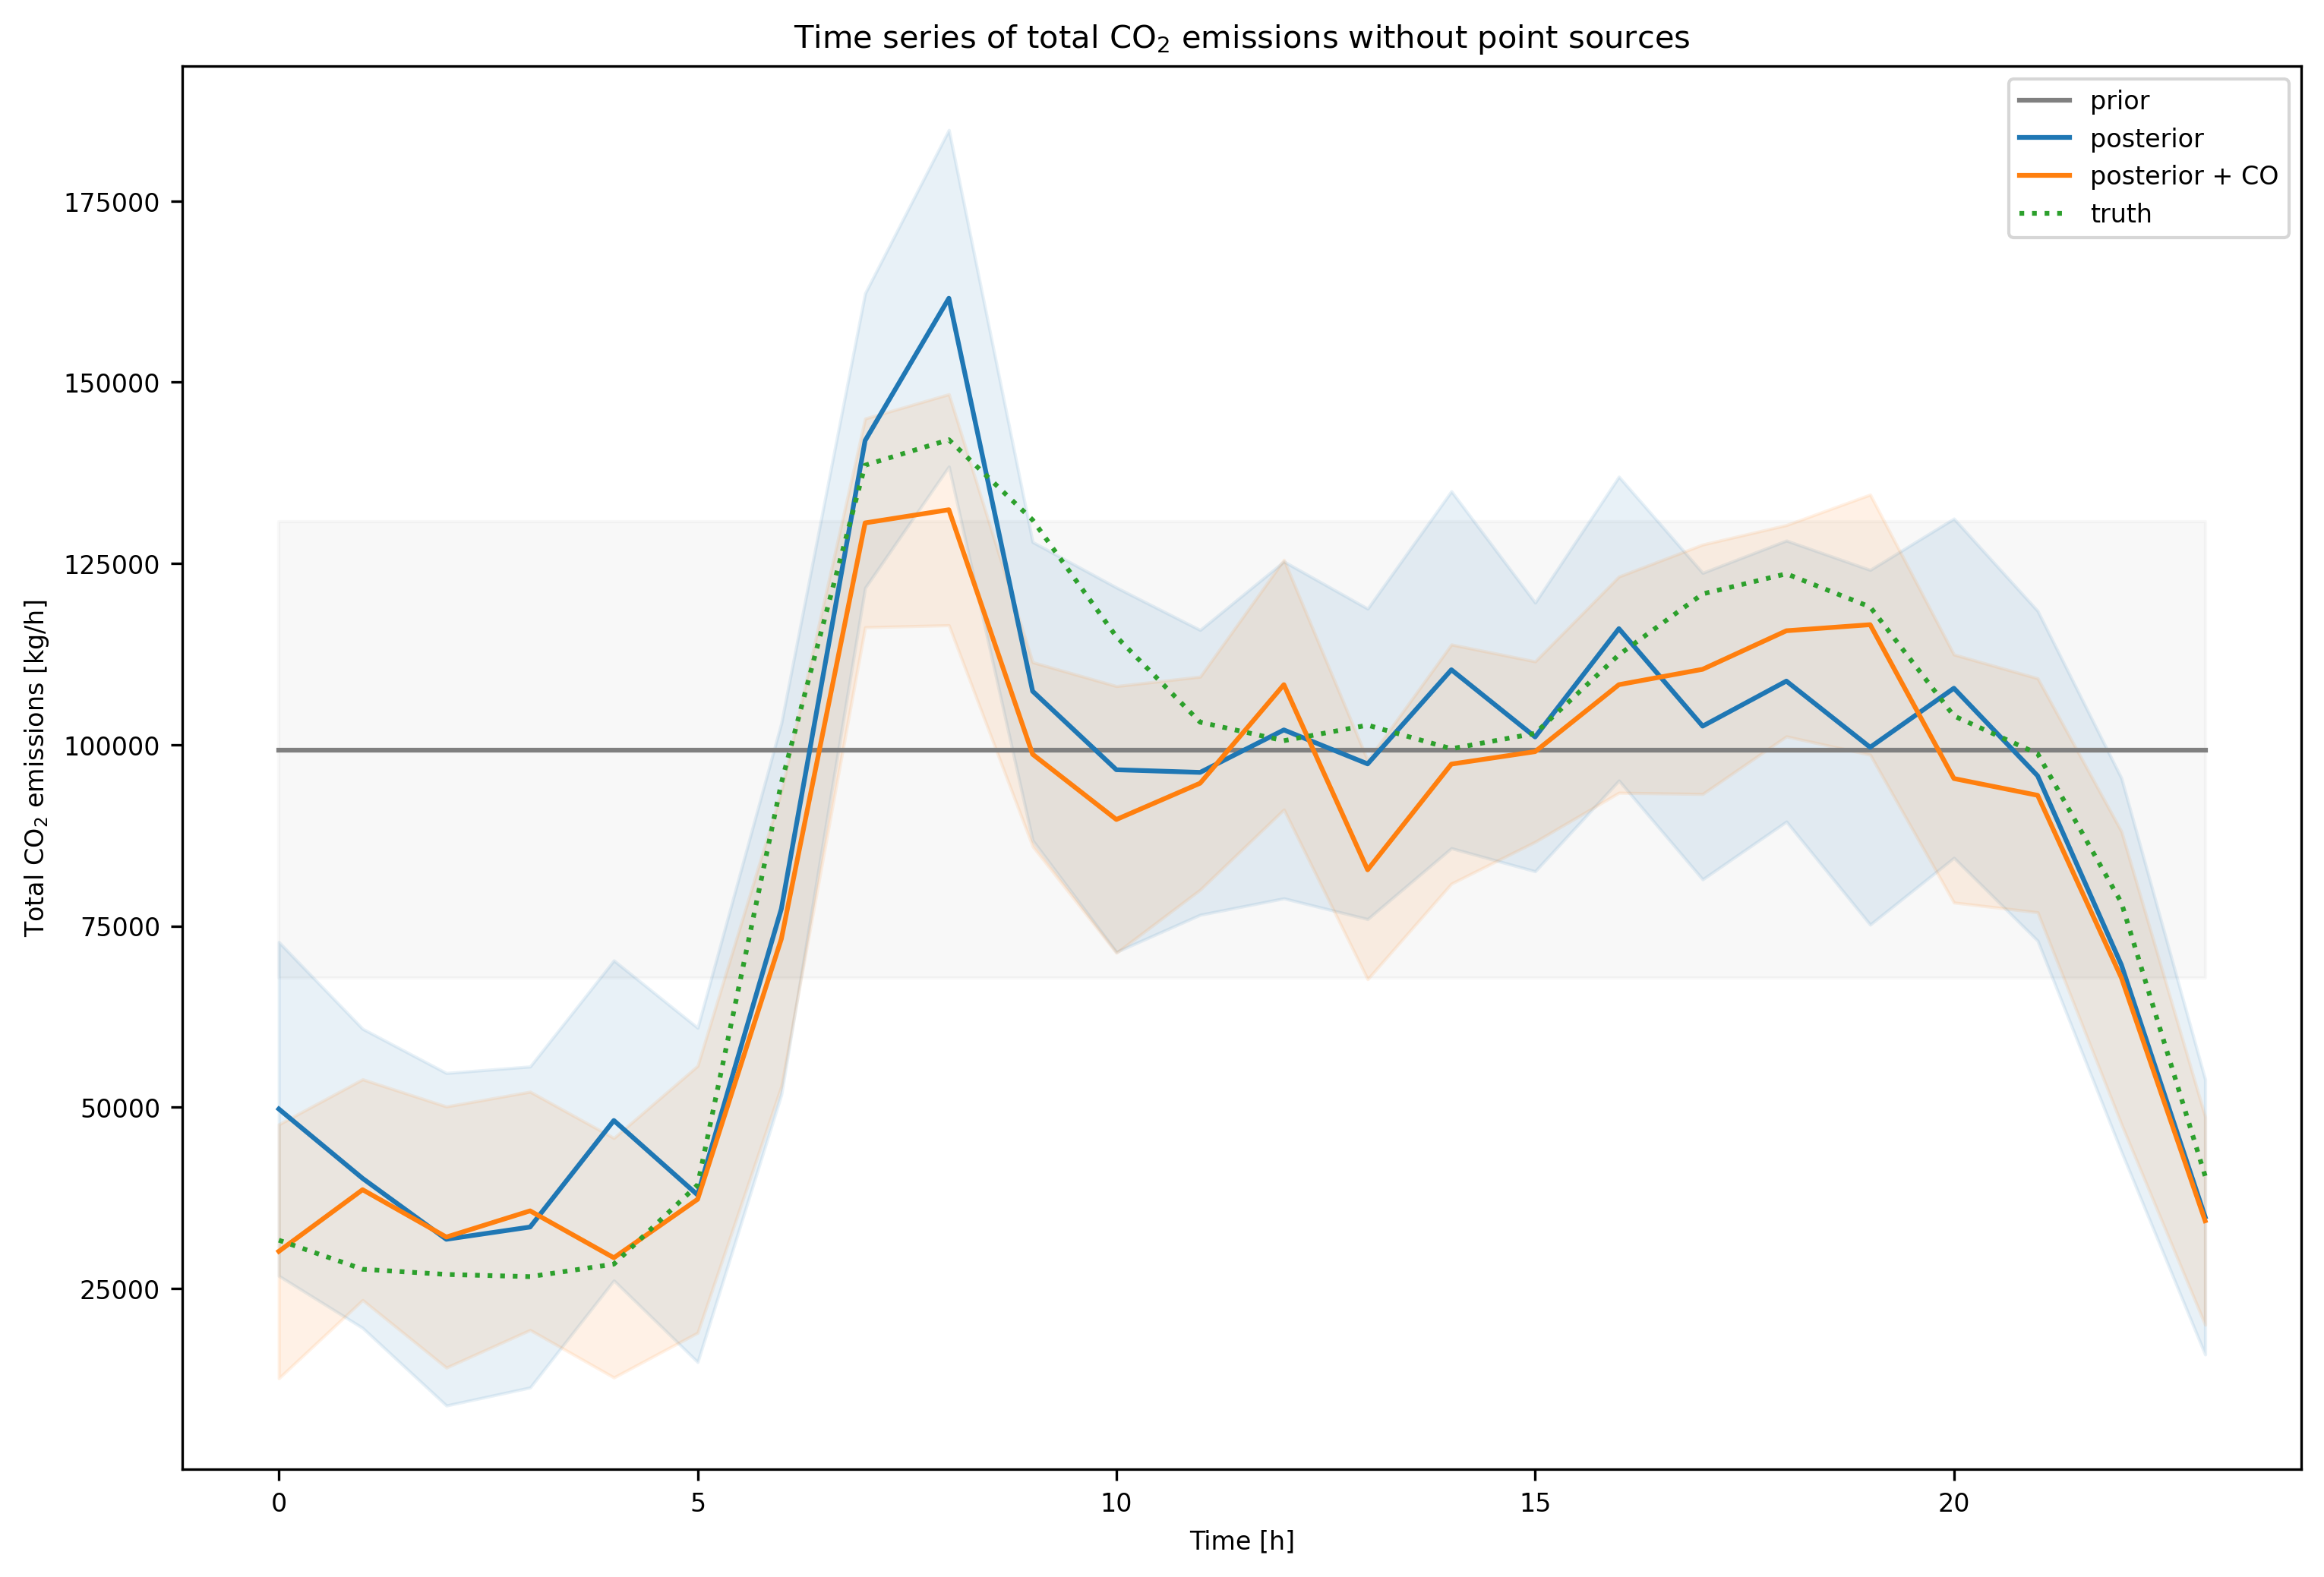

In [61]:
plt.figure(figsize=(12, 8))

mean_prior = exp.emissions.prior_absolute.isel(source_group=slice(1, None)).sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance.isel(source_group=slice(1, None))
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, color="grey", label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.05,
    color=line._color,
)

mean = posterior.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var)
line = plt.plot(mean, "-", label="posterior")[0]
rmse = np.sqrt(np.mean((mean - mean_prior)**2))
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1, color=line._color)

mean = posterior_combined.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior + CO")[0]
rmse_co = np.sqrt(np.mean((mean - mean_prior)**2))
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1, color=line._color)


plt.plot(
    exp.emissions.truth_absolute.isel(source_group=slice(1, None)).sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
# print((mean - mean_prior).mean())
plt.title(r"Time series of total CO$_2$ emissions without point sources")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig(
    "/home/rmaiwald/results/preliminary/more_trace_gases_timeseries_no_point_sources"
)
print("RMSE: {}".format(rmse))
print("RMSE with CO: {}".format(rmse_co))

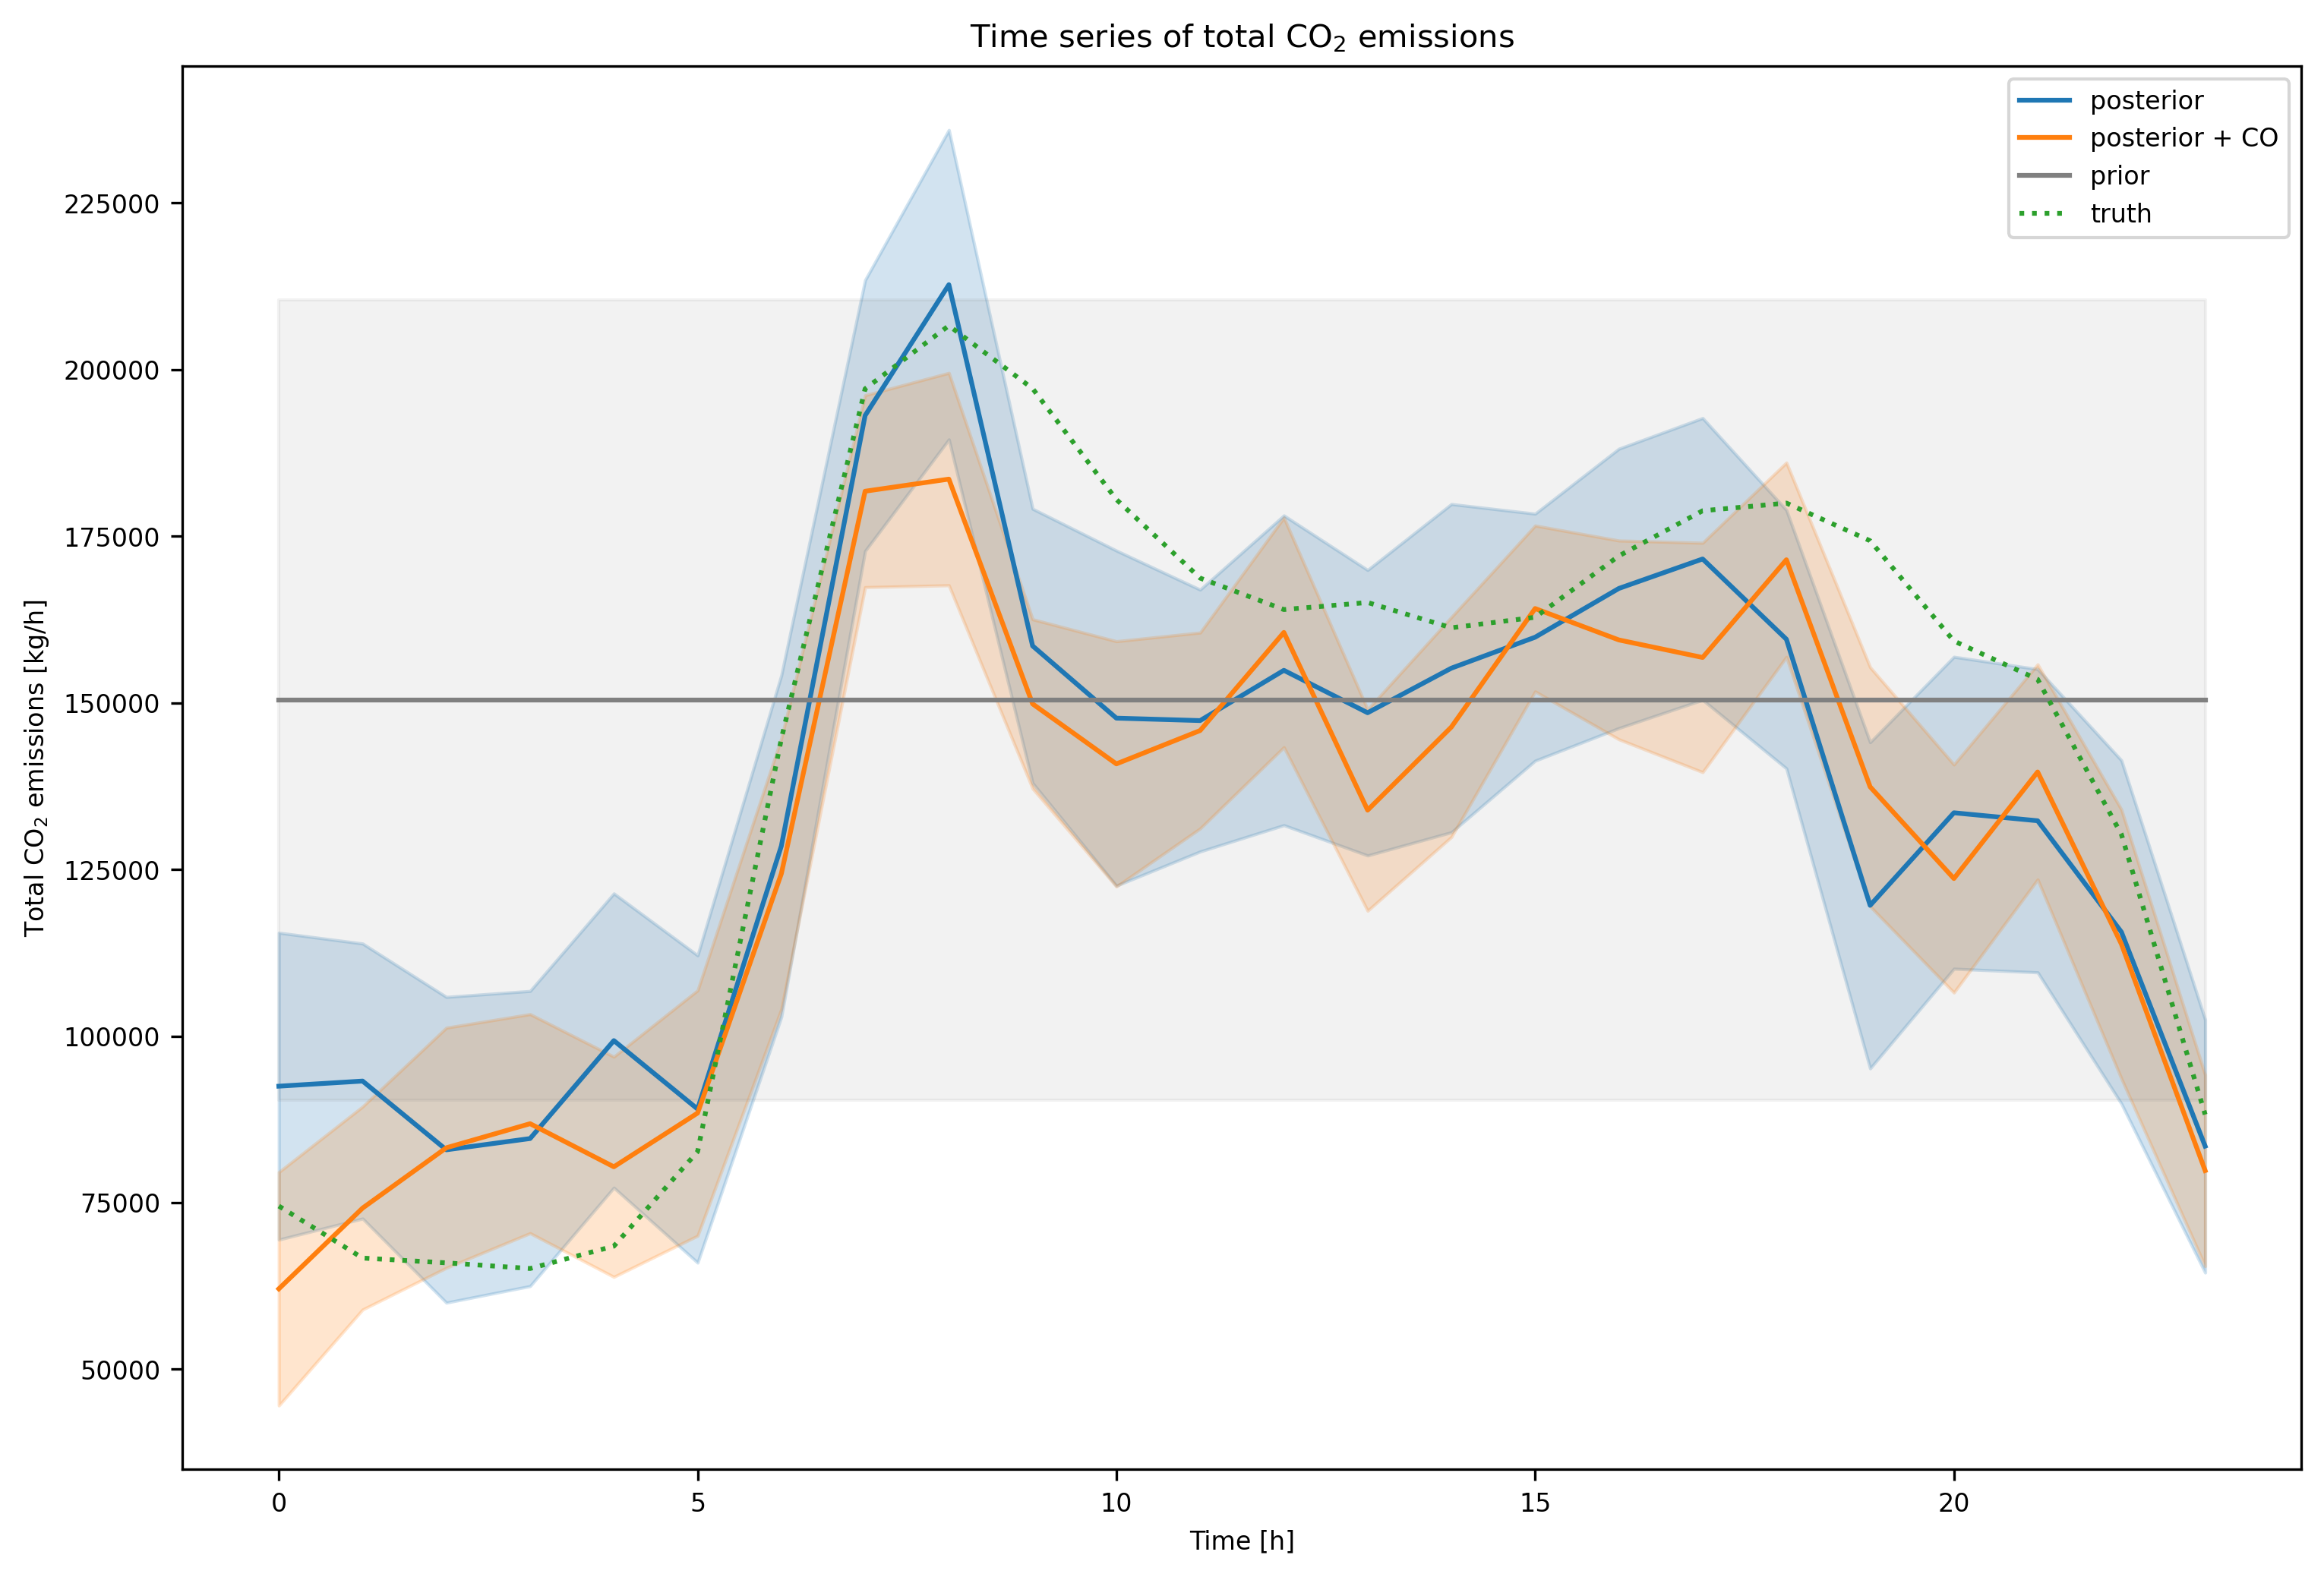

In [62]:
plt.figure(figsize=(12, 8))
mean = posterior.sum("source_group")
std = np.sqrt(var)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean = posterior_combined.sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior + CO")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean_prior = exp.emissions.prior_absolute.sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, color="grey", label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.1,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
# print((mean - mean_prior).mean())
plt.title(r"Time series of total CO$_2$ emissions")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig("/home/rmaiwald/results/preliminary/more_trace_gases_timeseries")

<xarray.DataArray ()>
array(-17965.11697716)


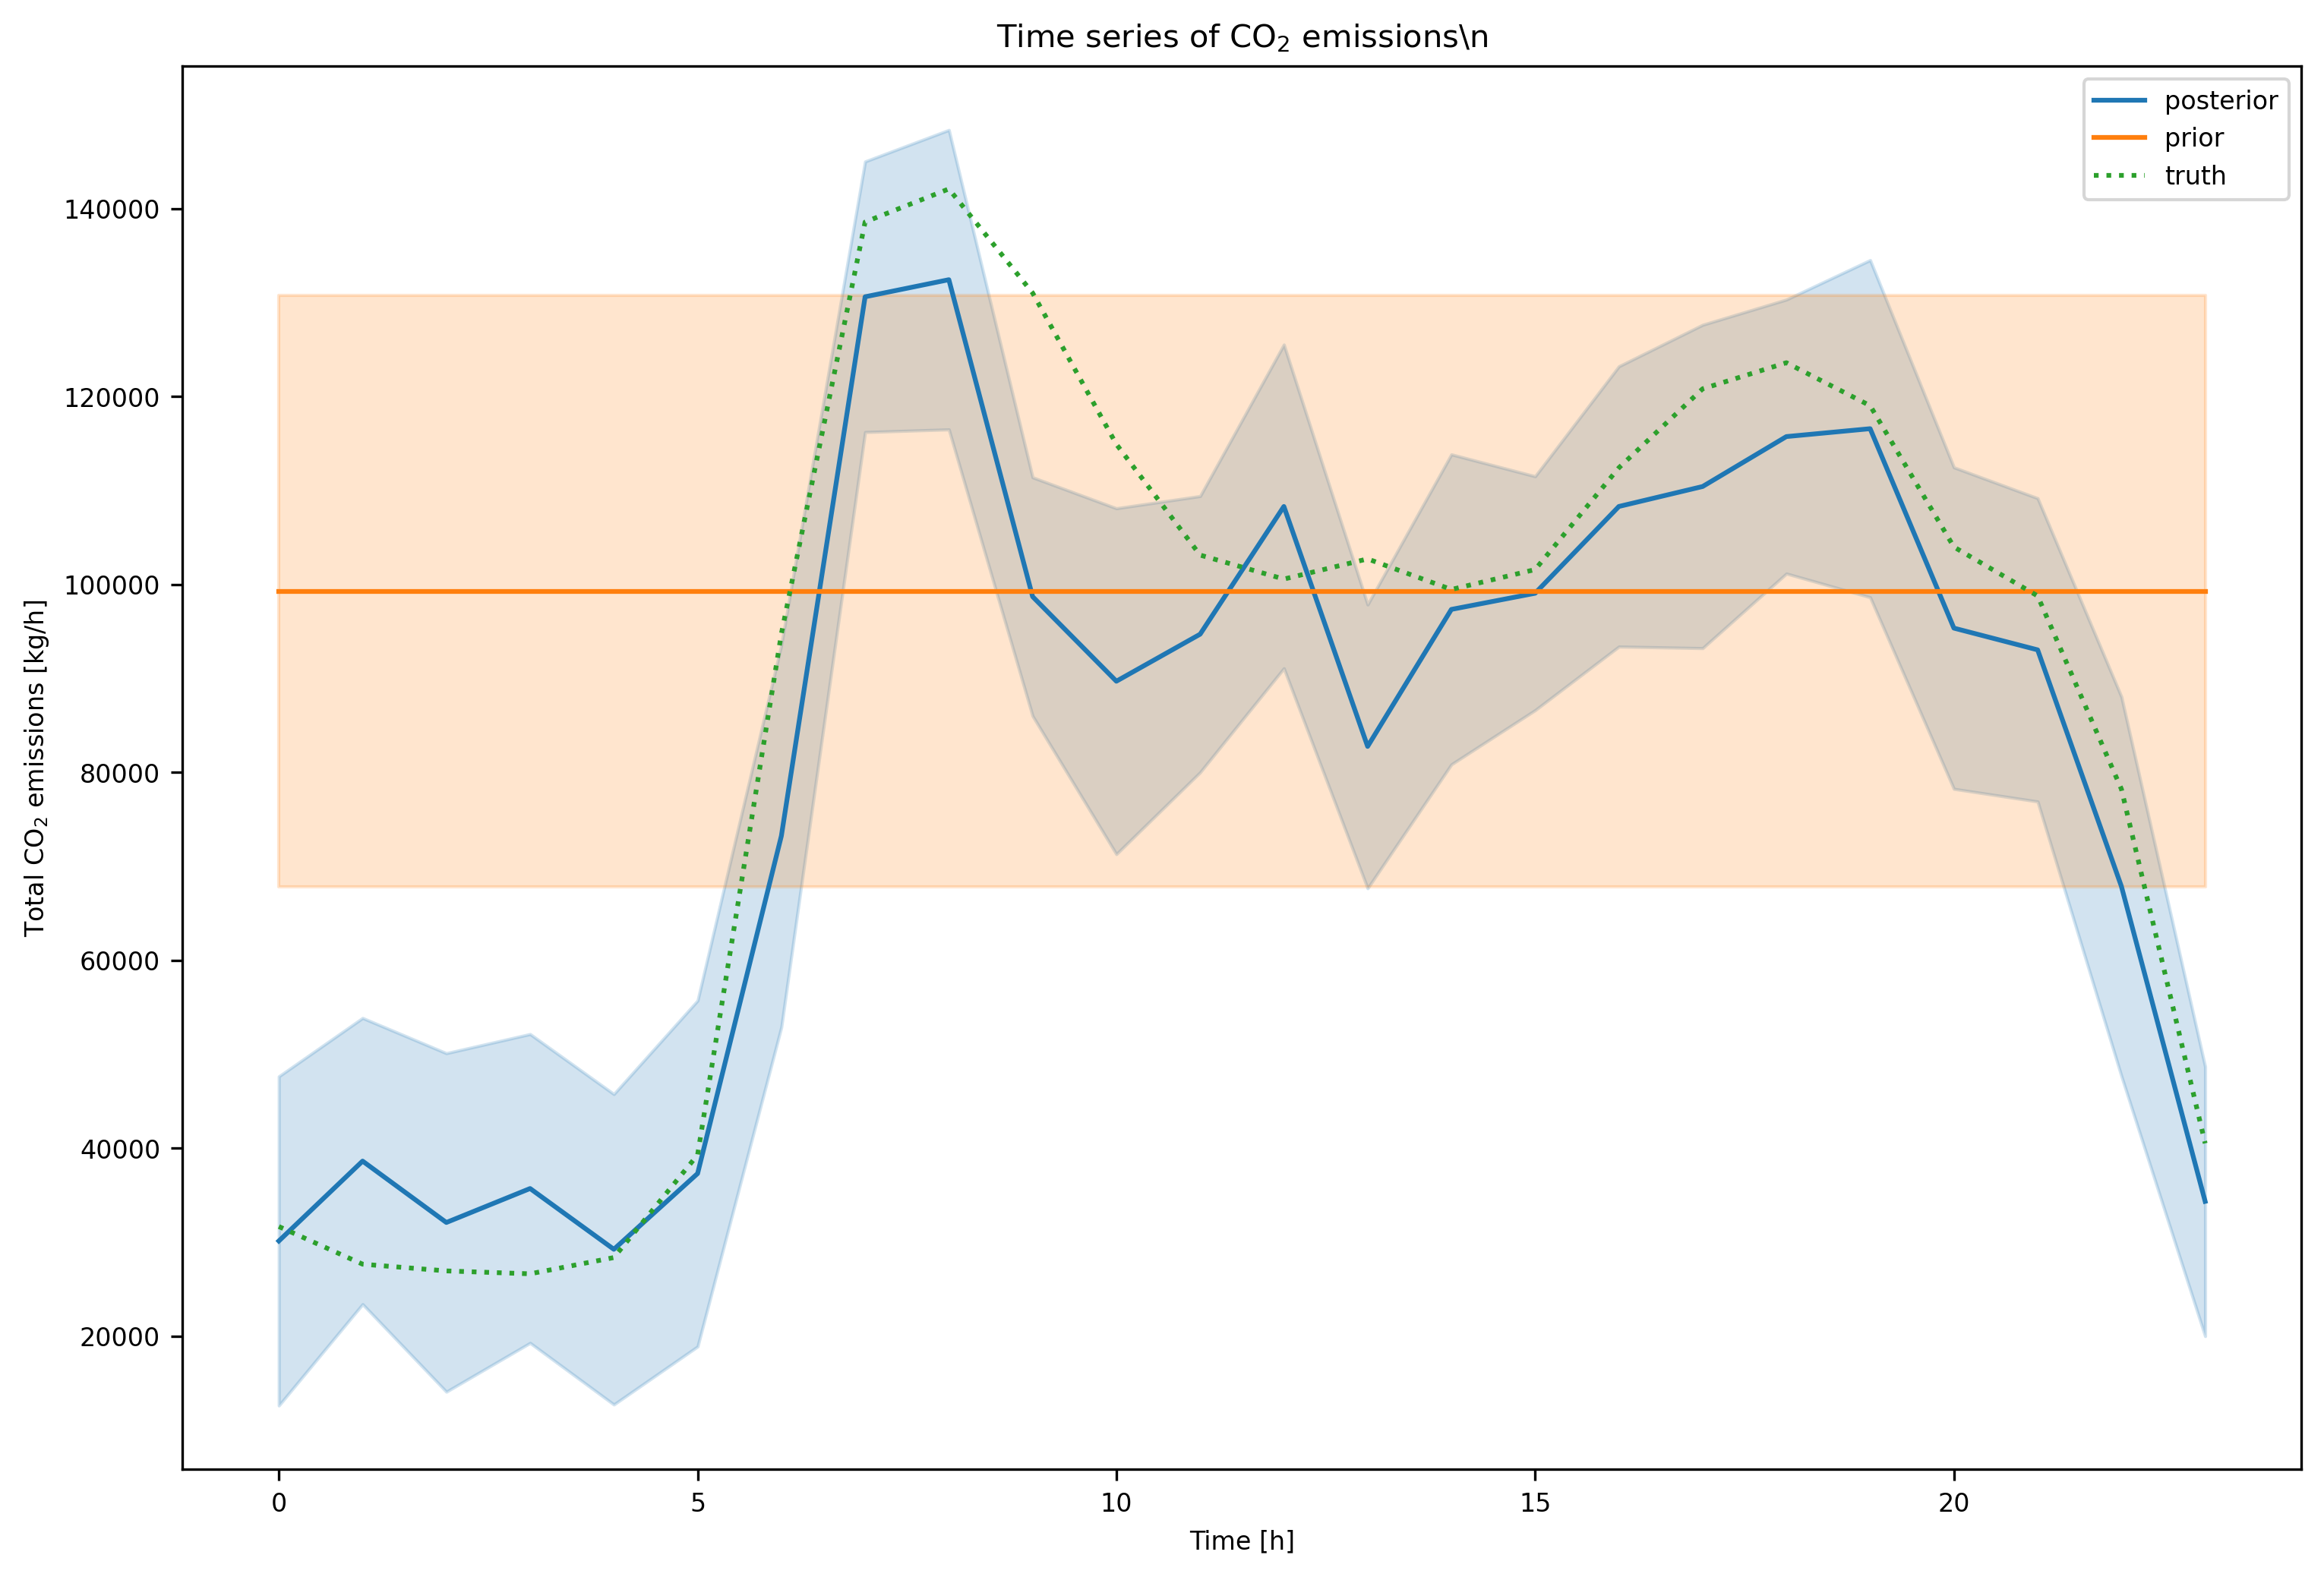

In [63]:
plt.figure(figsize=(12, 8))
mean = posterior_combined.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean_prior = exp.emissions.prior_absolute.isel(source_group=slice(1, None)).sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance.isel(source_group=slice(1, None))
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.2,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.isel(source_group=slice(1, None)).sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
print((mean - mean_prior).mean())
plt.title(r"Time series of CO$_2$ emissions\n")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig("/home/rmaiwald/results/preliminary/more_trace_gases_timeseries")